# PyTorch Workshop

[PyTorch](https://pytorch.org/) is a Python library that facilitates deep learning architectures.

In [1]:
import json
import collections
import tqdm
from typing import Literal, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Tensor

A PyTorch tensor is similar to a [NumPy](https://numpy.org/) array, in that it does not know anything about deep learning, computational graphs, or gradients; it is just a generic  𝑛 -dimensional array to be used for arbitrary numeric computation.

The biggest difference between a NumPy array and a PyTorch tensor is that a PyTorch Tensor can run on either CPU or GPU, whereas NumPy arrays can only run on CPU.

In [2]:
import torch

## 1.1.Tensor Initializations

In [3]:
x_rand = torch.rand(5, 3)
x_rand, x_rand.dtype

(tensor([[0.8818, 0.1742, 0.7008],
         [0.1262, 0.8461, 0.3436],
         [0.0081, 0.9212, 0.6058],
         [0.7823, 0.5208, 0.6736],
         [0.9492, 0.7331, 0.6784]]),
 torch.float32)

In [4]:
x_ones = torch.ones(5, 3, dtype=torch.long)
x_ones, x_ones.dtype

(tensor([[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]),
 torch.int64)

In [5]:
data = [[1, 2, 3], [4, 5, 6]]
x_data = torch.tensor(data)
x_data, x_data.dtype

(tensor([[1, 2, 3],
         [4, 5, 6]]),
 torch.int64)

In [6]:
x_np = np.array(data)
x_from_np = torch.from_numpy(x_np)
x_from_np, x_from_np.dtype

(tensor([[1, 2, 3],
         [4, 5, 6]]),
 torch.int64)

Take caution, as a tensor created from a NumPy array share the same memory, and thus modifying one causes the other to be changed as well:

In [7]:
x_np += 1
x_from_np

tensor([[2, 3, 4],
        [5, 6, 7]])

In [8]:
x_arange = torch.arange(0, 5, step=0.5)
x_arange

tensor([0.0000, 0.5000, 1.0000, 1.5000, 2.0000, 2.5000, 3.0000, 3.5000, 4.0000,
        4.5000])

## 1.3. Tensor operations

There are over 100 tensor operations, including arithmetic, linear algebra, matrix manipulation (transposing, indexing, slicing), sampling operations, and more. They are comprehensively described on the [PyTorch documentation page](https://pytorch.org/docs/stable/torch.html). We will go over several popular operations in this section.

In [9]:
x = torch.rand(2, 3)
y = torch.rand(2, 3)

In [10]:
z1 = x + y
z2 = torch.add(x, y)
z3 = x.add(y)
z4 = torch.rand_like(x)
torch.add(x, y, out=z4)

assert torch.equal(z1, z2)
assert torch.equal(z2, z3)
assert torch.equal(z3, z4)

In [11]:
z1 = x * y
z2 = torch.mul(x, y)    # or torch.multiply(x, y)
z3 = x.mul(y)           # or x.multiply(y)
z4 = torch.rand_like(x)
torch.mul(x, y, out=z4)

assert torch.equal(z1, z2)
assert torch.equal(z2, z3)
assert torch.equal(z3, z4)

In [12]:
y_t = y.t()               # (3, 2)
z = torch.matmul(x, y_t)  # (2, 3) x (3, 2)
z   

tensor([[0.6256, 0.5821],
        [0.6891, 0.2740]])

### Adding or removing a dimension

Sometimes, we seek to add or remove an empty dimension to ensure dimensionality matches. For this purpose, we use `torch.tensor.squeeze()` for **removing** and `torch.tensor.unsqueeze()` for **adding** a dimension.

In [13]:
x1 = torch.randn(2, 1, 1, 3)
x2 = x1.unsqueeze(dim=3)
x2.shape

torch.Size([2, 1, 1, 1, 3])

In [14]:
x3 = x2.squeeze(dim=3)
x3.shape

torch.Size([2, 1, 1, 3])

In [15]:
x4 = x3.squeeze()
x4.shape

torch.Size([2, 3])

### Reshaping tensors:

At times, we will need to reshape tensors to ensure appropriate dimensionality. For this purpose, PyTorch provides a few useful functions:

- Via [`torch.tensor.view()`](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html):

In [16]:
print(f"{x.shape = }")
x1 = x.view(6)
x1

x.shape = torch.Size([2, 3])


tensor([0.6718, 0.2930, 0.7849, 0.5564, 0.8098, 0.0289])

In [17]:
x2 = x.view(3, 2)
x2

tensor([[0.6718, 0.2930],
        [0.7849, 0.5564],
        [0.8098, 0.0289]])

In [18]:
x3 = x.view(-1, 2)
x3

tensor([[0.6718, 0.2930],
        [0.7849, 0.5564],
        [0.8098, 0.0289]])

- Via [`torch.reshape()`](https://pytorch.org/docs/stable/generated/torch.reshape.html#torch.reshape):

In [19]:
x4 = torch.reshape(x, (-1,)) # Same syntax as view
x4

tensor([0.6718, 0.2930, 0.7849, 0.5564, 0.8098, 0.0289])

A big difference between `view()` and `reshape()` is `view()` can only be called on **contiguous** tensors, or tensors whose values are stored consecutively without any space between them in memory. You can check contiguity by using [`torch.tensor.is_contiguous()`](https://pytorch.org/docs/stable/generated/torch.Tensor.is_contiguous.html).

When calling `view()`, PyTorch **does not** create a new copy of the tensor; it merely returns a _view_ of the same tensor. While `reshape()` can also return a view of a tensor, it may also create a new copy if necessary, and you do not know the behavior beforehand.

# 2. Autograd

[`torch.autograd`](https://pytorch.org/docs/stable/autograd.html) is PyTorch’s automatic differentiation engine that powers neural network training. The Autograd package provides automatic differentiation for all operations on tensors. It is a define-by-run framework, _i.e._, your backpropagation is defined by how your code is run, and that every single iteration can be different.

A gradient is similar to a derivative, but in vector form, and it is the core of backpropagation. To train a neural network, it is important to calculate a loss function and invoke backpropagation on it. However, such loss functions may be very complex and high-dimensional, rendering gradient computation impractical. Luckily, Autograd can find this gradient numerically in a matter of seconds.

Consider a simple equation: $y = x^2$.

In [20]:
x = torch.tensor([1., 2.], requires_grad=True)
y = x ** 2
y

tensor([1., 4.], grad_fn=<PowBackward0>)

We often invoke `.backward()` on a loss to trigger backpropagation. Note that we can only call this function on a **scalar tensor**; therefore, when the loss is a vector, we need to aggregate its parts, often by summing or averaging them.

Calling `backward()` on $y$ calculates $\frac{dy}{dx}$ for every $x$ involved in computing $y$ where `requires_grad` is `True`. This value is accumulated into `x.grad`, which contains the gradient of $x$.

In [21]:
y.sum().backward()
print(x.grad)

tensor([2., 4.])


If we do not wish to retain the gradients, we use the `torch.no_grad()` or `torch.inference_mode()` context managers:

In [22]:
with torch.no_grad():
    z = x ** 2
z

tensor([1., 4.])

We can see the difference between `y` and `z`: if we specify `torch.no_grad()` or `torch.inference_mode()`, we can't call `.backward()`, which is very important for neural network training. Therefore, we only want to do so when we do not want to update the gradients within a model.

# 3. A Simple Neural Network

In [23]:
import math

x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)    # 100 constant increments between -1 and 1
y = x.pow(2) + 0.3 * torch.rand(x.size())                 # y = x ** 2 plus random noise

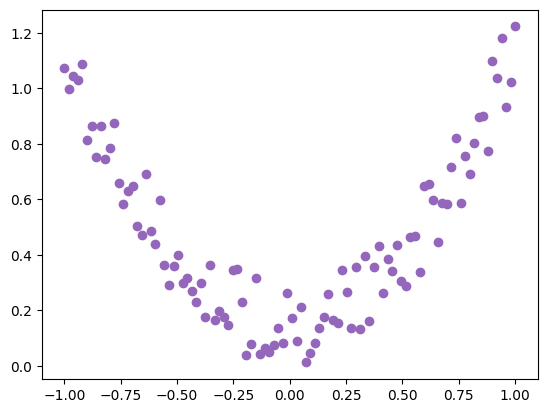

In [24]:
plt.scatter(x.data.numpy(), y.data.numpy(), color="tab:purple")
plt.show()

We will use a neural network to learn the underlying distribution of this data. In PyTorch, a nice way to build a network is by creating a new class for it. We import common PyTorch packages for deep learning:

In [25]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Let's create a neural network with 2 feed-forward layers and a [ReLU activation](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html) sandwiched in the middle. A deep learning model inherits from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) and needs a `forward()` function.

In [26]:
class NeuralNet(nn.Module):  
    def __init__(self, n_features: int, n_hidden: int, n_output: int):
        super().__init__() # initialize nn.Module 
        self.layer1 = nn.Linear(n_features, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_output)

    def forward(self, x: torch.Tensor):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

We create a new network with 1 input feature ($x$), a hidden size of 10, and 1 output feature ($\hat{y}$):

In [27]:
neural_net = NeuralNet(n_features=1, n_hidden=10, n_output=1)

Note that we could also use [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to simplify our network. This works well when our data would only be passed through layers sequentially in `forward()` without complex interactions:

In [28]:
neural_net_simplified = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(inplace=True),
    nn.Linear(10, 1)
)

We need an optimizer to update the gradients. Here, we employ a Stochastic Gradient Descent optimizer, initializing it with the parameters of our network and a learning rate of 0.2:

In [29]:
optimizer = optim.SGD(neural_net.parameters(), lr=0.2)

Lastly, we need a loss function for optimization. We use a simple Mean Squared Error loss:

In [30]:
criterion = nn.MSELoss()

With everything prepared, we are ready to write our training loop. We train our model for 100 epochs:

In [31]:
for epoch in range(200):
    prediction = neural_net(x)    
    loss = criterion(prediction, y)    

    optimizer.zero_grad()   # sets the stored backprop gradients to 0
    loss.backward()         # backpropagation      
    optimizer.step()        # performs a single optimization step (parameter update)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, loss = {loss.item():.5f}")

Epoch 0, loss = 0.26734
Epoch 10, loss = 0.05439
Epoch 20, loss = 0.04001
Epoch 30, loss = 0.03037
Epoch 40, loss = 0.02347
Epoch 50, loss = 0.01887
Epoch 60, loss = 0.01598
Epoch 70, loss = 0.01425
Epoch 80, loss = 0.01321
Epoch 90, loss = 0.01257
Epoch 100, loss = 0.01215
Epoch 110, loss = 0.01184
Epoch 120, loss = 0.01160
Epoch 130, loss = 0.01139
Epoch 140, loss = 0.01122
Epoch 150, loss = 0.01107
Epoch 160, loss = 0.01095
Epoch 170, loss = 0.01084
Epoch 180, loss = 0.01074
Epoch 190, loss = 0.01064


We find that our model is working, since the loss decreases as the number of epochs increases. Let's plot the training process of our model:

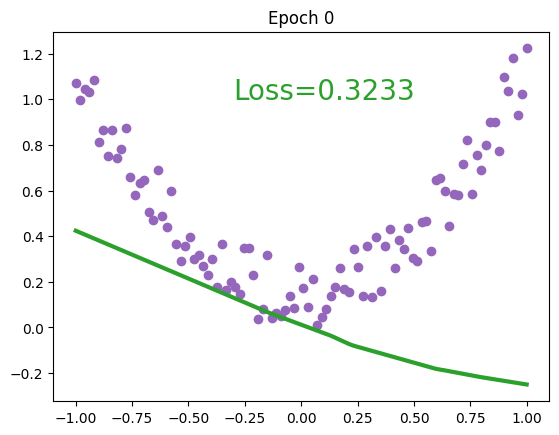

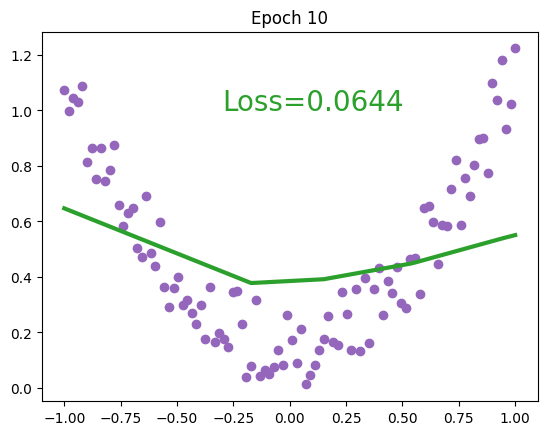

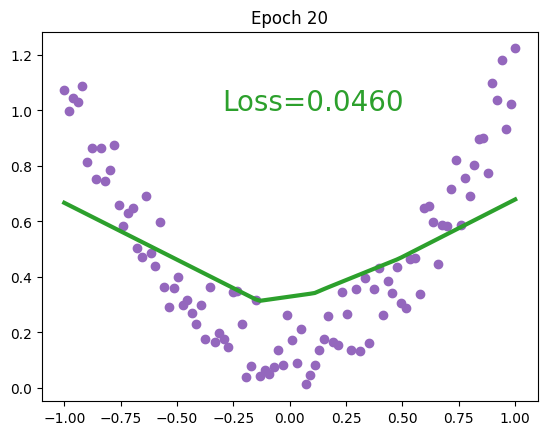

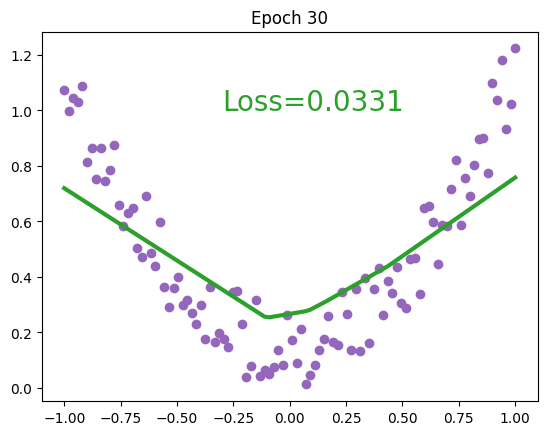

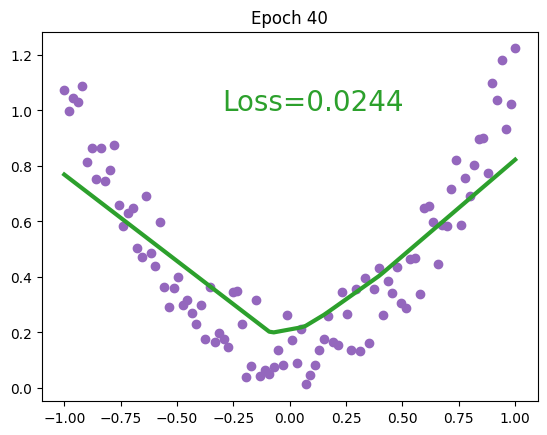

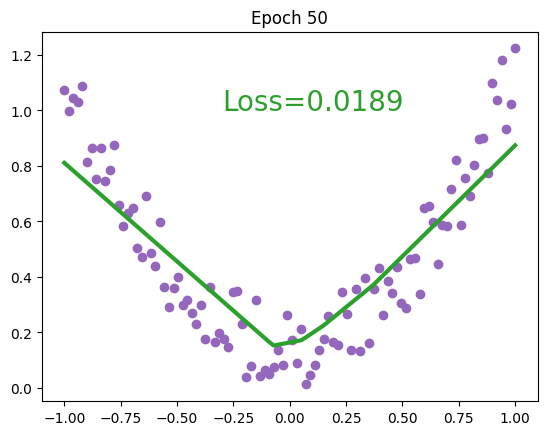

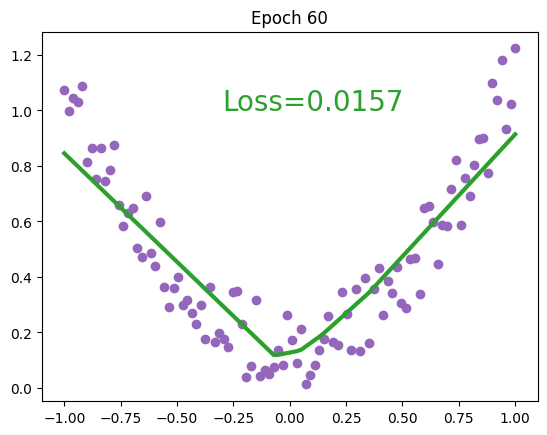

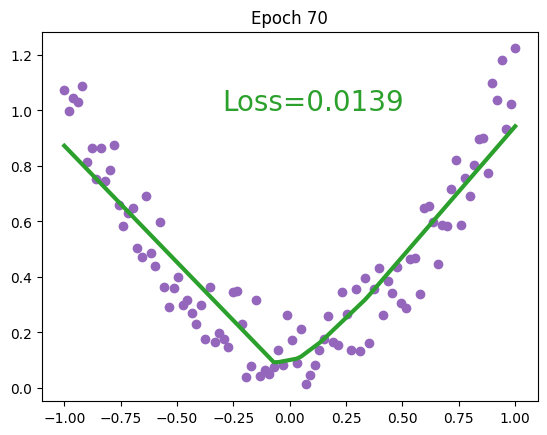

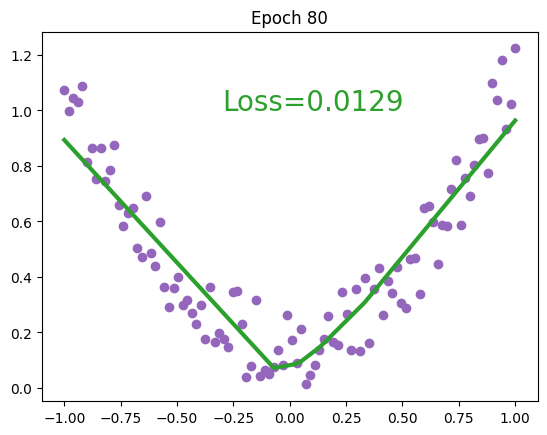

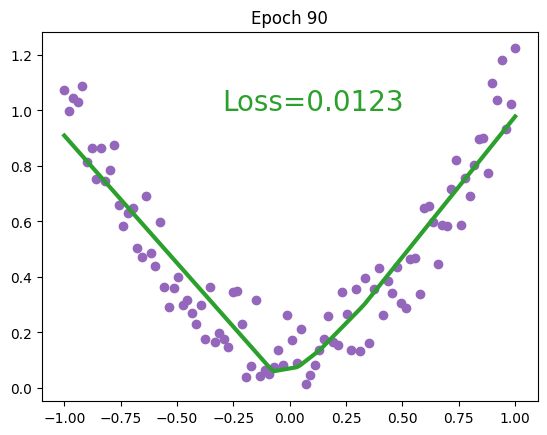

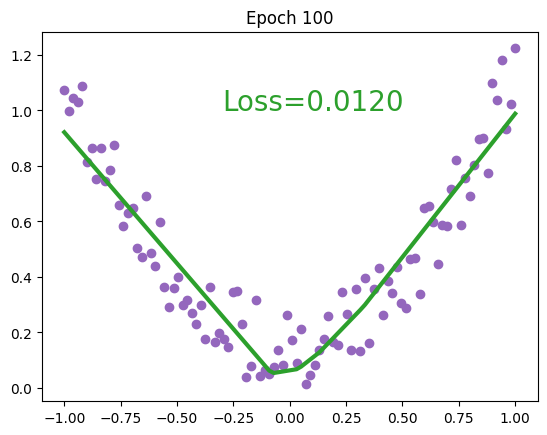

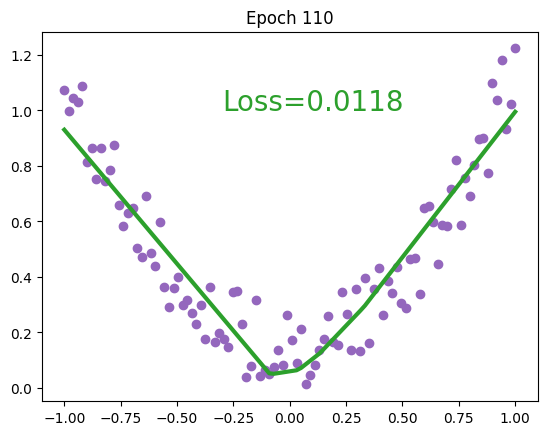

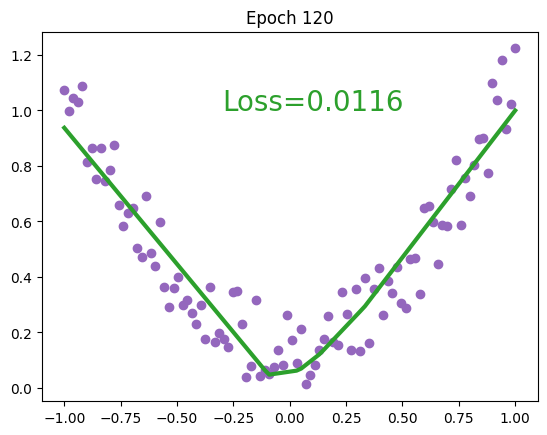

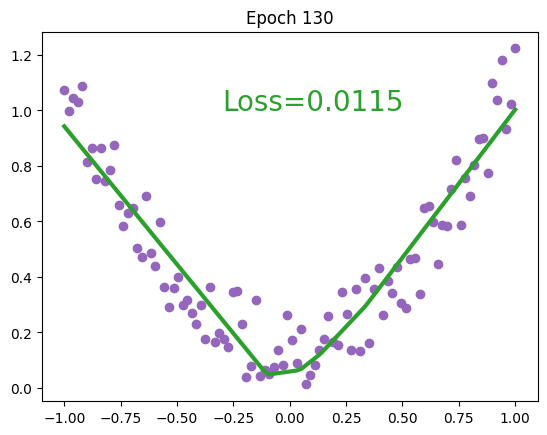

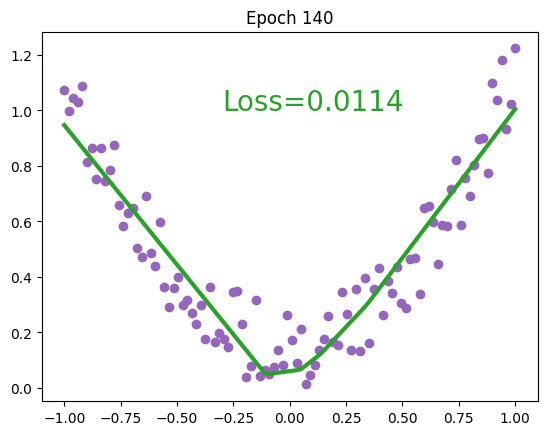

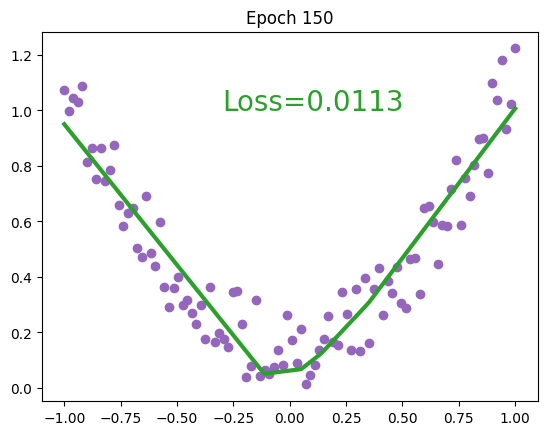

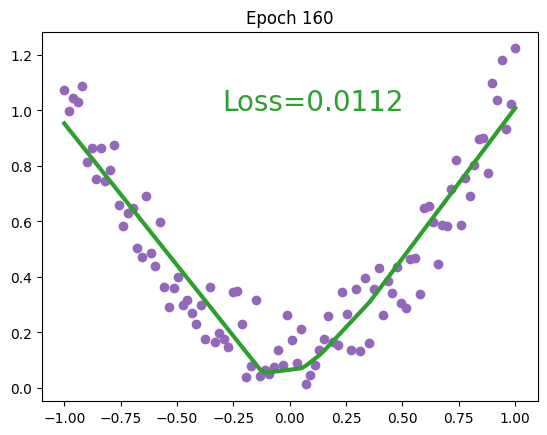

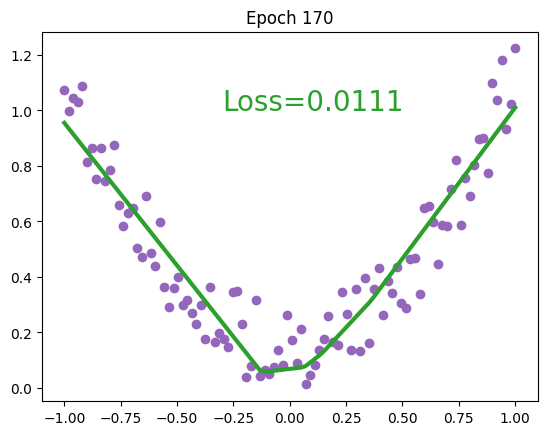

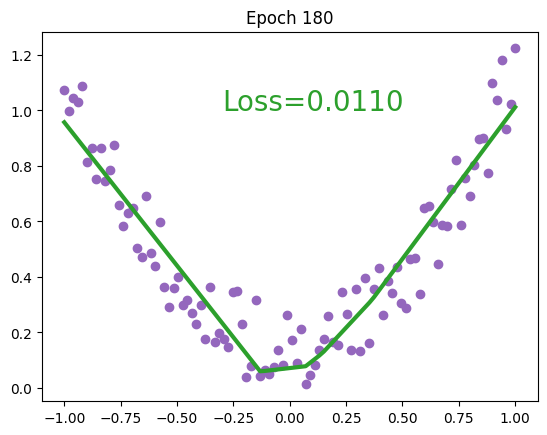

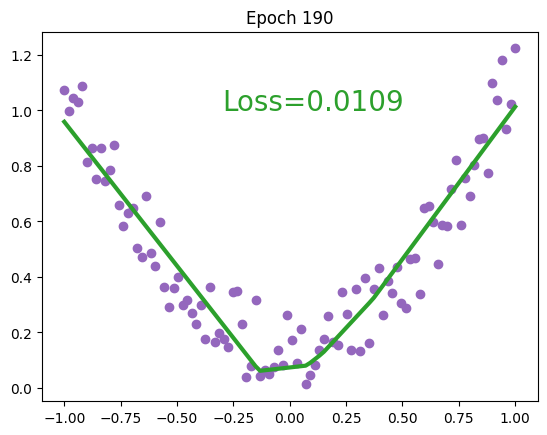

In [32]:
neural_net = NeuralNet(n_features=1, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(neural_net.parameters(), lr=0.2) 
criterion = torch.nn.MSELoss()

plt.ion() 
plt.show()

for epoch in range(200):
    prediction = neural_net(x)    
    loss = criterion(prediction, y)

    optimizer.zero_grad()   
    loss.backward()         
    optimizer.step()

    if epoch % 10 == 0:
        # plot and show learning process
        plt.cla()
        plt.title(f"Epoch {epoch}")
        plt.scatter(x.data.numpy(), y.data.numpy(), color="tab:purple")
        plt.plot(x.data.numpy(), prediction.data.numpy(), linestyle="-", color="tab:green", lw=3)
        plt.text(-0.3, 1, f"Loss={loss.data.numpy():.4f}", fontdict={"size": 20, "color": "tab:green"})
        plt.pause(0.1)

**Note**: Please remember to call `optimizer.zero_grad()` before backpropagation. Otherwise, a new gradient computation would also include old gradients, which you have already used to update your model parameters.

For more details about optimizers and loss functions, you can check out these official tutorials provided by PyTorch: [optimizers](https://pytorch.org/docs/stable/optim.html), [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions). 

# 4. Sentiment Analysis with RNNs

We have already examined feed-forward networks where inputs are multiplied by a weight $W$ and added to a bias $b$ multiple times, which finally results in an output from the last layer. However, a significant problem with these types of networks is that they cannot be used with sequential data. Therefore, Recurrent Neural Networks (RNN) were introduced to remedy this.

In this section, we will be using PyTorch to train a RNN for sentiment analysis.

In [34]:
# We will be using a dataset of preprocessed movie reviews for this section
train_df = pd.read_csv("./train.csv", header=0)
test_df = pd.read_csv("./test.csv", header=0)

In [35]:
train_df.head()

,sentiment,review
0,positive,one reviewer mentioned watching oz episode hoo...
1,positive,wonderful little production filming technique ...
2,positive,thought wonderful way spend time hot summer we...
3,negative,basically family little boy jake think zombie ...
4,positive,petter matteis love time money visually stunni...


In [36]:
train_df["review"].iat[0]

'one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show would dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience w

In [37]:
print(f"Train dataset size: {len(train_df)}")
print(f"Test dataset size: {len(test_df)}")

Train dataset size: 12810
Test dataset size: 9999


In [38]:
print(f"Train dataset size: {len(train_df)}")
print(f"Test dataset size: {len(test_df)}")

Train dataset size: 12810
Test dataset size: 9999


## 4.1. Text processing

Let's build a vocabulary that we can use to perform sentiment analysis. First, we want to tokenize our text. For this, we can use [TorchText](https://pytorch.org/text/stable/index.html), a PyTorch library with many tools for text manipulation. Here's an example:

In [39]:
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english")
tokens = tokenizer("This is a TEST sentence!")
tokens

['this', 'is', 'a', 'test', 'sentence', '!']

Our vocabulary should contain every token within our corpus, as well as special tokens denoting the start and end of sentence and padding.

In [40]:
vocabulary = set()
vocabulary.add("<START>")
vocabulary.add("<END>")
vocabulary.add("<PAD>")

for df in [train_df, test_df]:
    for idx, review in df.review.items():
        tokens = tokenizer(review)
        df.review.iat[idx] = tokens
        for word in tokens:
            vocabulary.add(word)

train_df.head()

,sentiment,review
0,positive,"[one, reviewer, mentioned, watching, oz, episo..."
1,positive,"[wonderful, little, production, filming, techn..."
2,positive,"[thought, wonderful, way, spend, time, hot, su..."
3,negative,"[basically, family, little, boy, jake, think, ..."
4,positive,"[petter, matteis, love, time, money, visually,..."


In [41]:
print(f"Vocabulary size: {len(vocabulary):,}")
print(f"First 10 words of vocabulary: {', '.join(list(vocabulary)[:10])}")

Vocabulary size: 92,856
First 10 words of vocabulary: scripture, ronni, wetdreams, themself, foresee, zeff, patriotism, wrack, rumination, riske


Now we need a lookup dictionary to convert our words into IDs:

In [42]:
word2id = {word: id for id, word in enumerate(vocabulary)}
print(f"{word2id['<START>'] = }")
print(f"{word2id['food'] = }")

word2id['<START>'] = 85937
word2id['food'] = 47270


We then want to convert our reviews into sequences of numbers using our `word2id` dictionary.

In addition, all inputs fed into an RNN should have the same size, meaning that all tokenized sentences must be of equal length. However, this is rarely ever true for real-world datasets, including ours. Therefore, we assign beforehand a **constant maximum length** for our inputs

For example, if we set the maximum length of the input sequence to 100, each sentence then has at most 100 tokens. If a sentence is less than 100 tokens long, we pad it until there are 100 tokens. If a sentence is more than 100 tokens long, we truncate it down to the maximum length.

We write the following `encode_and_pad()` function to simultaneously convert a sentence into IDs and pad it:

In [43]:
def encode_and_pad_wrapper(max_len: int):
    def encode_and_pad(tokens: List[str]):
        start = [word2id["<START>"]]
        end = [word2id["<END>"]]
        pad = [word2id["<PAD>"]]

        if len(tokens) < max_len - 2: # 2 tokens for <START> and <END>
            n_pads = max_len - 2 - len(tokens)
            encoded = [word2id[token] for token in tokens]
            return start + encoded + end + pad * n_pads 
        else: 
            encoded = [word2id[token] for token in tokens]
            truncated = encoded[:max_len - 2]
            return start + truncated + end
    return encode_and_pad

We also want to map our labels to numbers. Here, we want `0` to represent `negative` and `1` positive reviews:

In [44]:
map_label = lambda sentiment: int(sentiment == "positive")

Finally, we convert our data into tokens for training:

In [45]:
train_df.sentiment = train_df.sentiment.apply(map_label)
train_df.review = train_df.review.apply(encode_and_pad_wrapper(100))
train_df = train_df.rename(columns={"sentiment": "label", "review": "input_ids"})

test_df.sentiment = test_df.sentiment.apply(map_label)
test_df.review = test_df.review.apply(encode_and_pad_wrapper(100))
test_df = test_df.rename(columns={"sentiment": "label", "review": "input_ids"})

In [46]:
train_df.head()

,label,input_ids
0,1,"[85937, 6495, 55625, 6471, 33499, 18976, 55006..."
1,1,"[85937, 37714, 32768, 91243, 37966, 49470, 424..."
2,1,"[85937, 36474, 37714, 805, 66447, 1081, 661, 7..."
3,0,"[85937, 33457, 29679, 32768, 84617, 41252, 592..."
4,1,"[85937, 81852, 75323, 5537, 1081, 20517, 12762..."


## 4.2. Putting everything together: A custom Dataset

PyTorch provides utilities for data storing and loading in the [`torch.utils.data`](https://pytorch.org/docs/stable/data.html) package.

In [47]:
from torch.utils.data import Dataset, DataLoader

Essentially, to train and test every deep learning model, you need a [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class to store data, alongside a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to retrieve batched data from the Dataset class.

Dataset classes are either map-style or iterable-style; we will be using a map-style `Dataset` in this example. A map-style Dataset extends `torch.utils.data.Dataset` and has a `__len__()` method specifying the size of the dataset, as well as a `__getitem__(idx)` method to obtain the sample at index `idx`. Let's create our custom Dataset:

In [48]:
class RNNDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        df.reset_index(drop=True, inplace=True)
        self.df = df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        input_ids = torch.tensor(row["input_ids"])
        label = torch.tensor(row["label"])
        return (input_ids, label)

In [49]:
train_rnn_ds = RNNDataset(train_df)
test_rnn_ds = RNNDataset(test_df)
print(f"Size of train set: {len(train_rnn_ds)}")
print(f"Item at index 16 of train set:\n{train_rnn_ds[16]}")

Size of train set: 12810
Item at index 16 of train set:
(tensor([85937, 15556, 49586, 57528,  6495, 35377, 15556, 78569, 51252, 61581,
        44652, 15556, 37983, 55135, 87865, 10601, 48838, 87497, 37962, 73270,
        91344, 70191, 19065, 65182, 13089, 59179, 48376, 56404, 60844, 74657,
        26102, 32434, 92534, 84405, 68947, 46650, 78938, 88650,  2361,  1658,
        15556,   953, 74089,  6635,  7651, 20786, 35377, 15556,  7600, 74951,
        44652, 89650, 74657,  1015, 76157, 60317, 60317, 60317, 60317, 60317,
        60317, 60317, 60317, 60317, 60317, 60317, 60317, 60317, 60317, 60317,
        60317, 60317, 60317, 60317, 60317, 60317, 60317, 60317, 60317, 60317,
        60317, 60317, 60317, 60317, 60317, 60317, 60317, 60317, 60317, 60317,
        60317, 60317, 60317, 60317, 60317, 60317, 60317, 60317, 60317, 60317]), tensor(1))


However, a DataLoader is often used to batch data from a Dataset for efficient training. We create DataLoaders from Datasets as follows:

In [50]:
batch_size = 64
train_rnn_dl = DataLoader(train_rnn_ds, batch_size=batch_size, shuffle=True, drop_last=True)
test_rnn_dl = DataLoader(test_rnn_ds, batch_size=batch_size, shuffle=False, drop_last=True)

Note that `shuffle` is `True` for the train loader, but `False` for the test loader. This is because we want to shuffle data for training to avoid any kind of order-induced bias, but this is not necessary for testing.

Also note the `drop_last` parameter being set to `True`. This is useful for when the final batch does not have 64 elements; the batch is then incomplete and will cause dimension errors if fed into our model. By setting this parameter to `True`, we drop the final batch and avoid errors.

Now, our DataLoaders can load batched data from our Datasets. DataLoaders are iterators:

In [51]:
train_dl_iter = iter(train_rnn_dl)
batch = next(train_dl_iter)
batch

[tensor([[85937,   748, 26212,  ...,  6351, 84162, 76157],
         [85937,   518, 73201,  ..., 61933,  1555, 76157],
         [85937, 51397,  6326,  ..., 38219, 77590, 76157],
         ...,
         [85937, 24323, 85262,  ..., 60317, 60317, 60317],
         [85937,  9261, 52921,  ..., 73806, 76157, 60317],
         [85937, 58130, 12100,  ..., 60317, 60317, 60317]]),
 tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
         0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
         1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1])]

In [52]:
batch[0].shape

torch.Size([64, 100])

## 4.3. RNN architecture

Let's write some code for our simple RNN architecture. We first want an [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) to get embeddings from fixed token indices, which we already have. We then feed the embeddings into an [`nn.RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), then pass them through a feed-forward layer to get final predictions.

Here, `vocab_size` is our vocabulary size, `embedding_dim` is the dimension of our text embeddings, `hidden_size` is the RNN's hidden size, `n_layers` is the RNN's layer count, and `n_classes` is the number of output classes.

In [53]:
class RNN(nn.Module):
    def __init__(
            self,
            vocab_size: int, 
            embedding_dim: int = 50,
            hidden_size: int = 128,
            n_layers: int = 2,
            n_classes: int = 2
        ):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):             # (bsz, 100)
        x = self.embedding(x)         # (bsz, 100, embedding_dim)
        outputs, _ = self.rnn(x)      # (bsz, 100, hidden_size)
        outputs = outputs[:, -1, :]   # (bsz, hidden_size): get final hidden states only
        outputs = self.fc(outputs)    # (bsz, n_classes)
        return outputs

In [54]:
rnn = RNN(len(word2id))

To get an idea of how big our model is, we can take a look at its **number of trainable parameters**. We can compute that by running this code:

In [55]:
print(f"Trainable parameter count: {sum(p.numel() for p in rnn.parameters() if p.requires_grad):,}.")

Trainable parameter count: 4,699,122.


For a more in-depth idea of your models' memory consumption, you can look into using a [PyTorch Profiler](https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html).

## 4.4. Training and testing

We are finally ready to train our RNN! Let's first write a general `train()` function that can be used to train any simple model:

In [56]:
def train(model, train_dl, n_epochs, optimizer, criterion, batch_size=64):
    model.train()

    for epoch in range(n_epochs):
        train_loss = 0.0
        
        for i, (inputs, labels) in enumerate(train_dl):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        train_loss = train_loss/(len(train_dl.dataset) // batch_size)

        print(f"Epoch {epoch + 1}: Loss {train_loss:.5f}")

    print("Finished training.")

We can now train our RNN! Let's declare the loss and optimizer for our model and train it for 10 epochs:

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr = 1e-4)
train(rnn, train_rnn_dl, 10, optimizer, criterion)

Epoch 1: Loss 0.69560
Epoch 2: Loss 0.69267
Epoch 3: Loss 0.69101
Epoch 4: Loss 0.68926
Epoch 5: Loss 0.68663
Epoch 6: Loss 0.68401
Epoch 7: Loss 0.68167
Epoch 8: Loss 0.67709
Epoch 9: Loss 0.67439
Epoch 10: Loss 0.67067
Finished training.


# 5. Image Classification with CNNs

In [58]:
import torch
import torchvision
import torchvision.transforms as transforms

Here, we use [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html) to convert images into tensors, then [`transforms.Normalize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Normalize.html) to normalize them, and finally [`transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html) to combine them together.

Let's use a batch size of 4 for training and testing, alongside a `num_workers` value of 2 (_i.e._, using 2 subprocesses to asynchronously load data).

In [59]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 104365162.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [60]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

We instantiate our model and check its trainable parameter count:

In [61]:
net = CNN()
print(f"Trainable parameter count: {sum(p.numel() for p in net.parameters() if p.requires_grad):,}.")

Trainable parameter count: 62,006.


Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Let's train our CNN for 10 epochs

In [63]:
train(net, trainloader, 10, optimizer, criterion)

Epoch 1: Loss 26.77793
Epoch 2: Loss 21.37870
Epoch 3: Loss 19.11910
Epoch 4: Loss 17.46721
Epoch 5: Loss 16.38413
Epoch 6: Loss 15.44775
Epoch 7: Loss 14.71402
Epoch 8: Loss 14.18180
Epoch 9: Loss 13.57546
Epoch 10: Loss 13.13494
Finished training.


In [64]:
# save the model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [65]:
# evaluation

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %
